# Running multi-container endpoints on Amazon SageMaker

SageMaker multi-container endpoints enable customers to deploy multiple containers to deploy different models on a SageMaker endpoint. The containers can be run in a sequence as an inference pipeline, or each container can be accessed individually by using direct invocation to improve endpoint utilization and optimize costs.


This notebook shows how to create a multi-container endpoint which will host both the PyTorch(>=1.5) model and a TensorFlow(>=2.0) model, on a single endpoint. Here, `Direct` invocation behavior of multi-container endpoints is showcased where each model container can be invoked directly rather than being called in a sequence.

This notebook is divided in the following sections:

1. **Pre-requisites**
1. **Train a TensorFlow Model in SageMaker**
1. **Train a PyTorch Model in SageMaker**
1. **Setup Multi-container Endpoint with Direct Invocation**
1. **Inference**
1. **Clean up**

## Section 1: Pre-requisites

First, import some necessary libraries and variables. This is the place where the output paths for the models are defined.

In [1]:
import os
import json
import time
import random
import numpy as np
from utils.mnist import mnist_to_numpy, normalize
import random
import matplotlib.pyplot as plt

import boto3
import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.s3 import S3Downloader
from sagemaker.s3 import S3Uploader

sess = sagemaker.Session()

role = get_execution_role()

bucket = sess.default_bucket()

output_prefix = "/multi-container-endpoint/output"
output_path = "s3://" + bucket + output_prefix

region = sess.boto_region_name

sm_client = sess.sagemaker_client
runtime_sm_client = sess.sagemaker_runtime_client
s3_client = boto3.client("s3")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [2]:
print(output_path)

s3://sagemaker-us-east-1-903094584798/multi-container-endpoint/output


### Dataset

This notebook uses `MNIST` dataset. `MNIST` is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled `28x28` pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). 

### Set up channels for training and testing data

Next, the framework Estimator needs to know where to find the training and testing data. It can be a link to an S3 bucket, or it can be a path in the local file system if local mode is used. For this notebook, download the `MNIST` data from a public S3 bucket and upload it to the default bucket created in the first cell. 

__NOTE: Local mode is not supported in Studio.__

In [3]:
import logging
import boto3
from botocore.exceptions import ClientError

# Download training and testing data from a public S3 bucket


def download_from_s3(data_dir="/tmp/data", train=True):
    """Download MNIST dataset and convert it to numpy array

    Args:
        data_dir (str): directory to save the data
        train (bool): download training set

    Returns:
        None
    """

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if train:
        images_file = "train-images-idx3-ubyte.gz"
        labels_file = "train-labels-idx1-ubyte.gz"
    else:
        images_file = "t10k-images-idx3-ubyte.gz"
        labels_file = "t10k-labels-idx1-ubyte.gz"

    with open("utils/config.json", "r") as f:
        config = json.load(f)

    # download objects
    s3 = boto3.client("s3")
    bucket = config["public_bucket"]
    for obj in [images_file, labels_file]:
        key = os.path.join("datasets/image/MNIST", obj)
        dest = os.path.join(data_dir, obj)
        if not os.path.exists(dest):
            s3.download_file(bucket, key, dest)
    return


download_from_s3("/tmp/data", True)
download_from_s3("/tmp/data", False)

### Create channels for SageMaker Training

The keys of the dictionary `channels` are parsed to the training image, and it creates the environment variable `SM_CHANNEL_<key name>`. 

In this example, `SM_CHANNEL_TRAINING` and `SM_CHANNEL_TESTING` are created in the training image (checkout how `tensorflow/train.py` or `pytorch/train.py` to learn how to access these variables). For more information, see: [SM_CHANNEL_{channel_name}](https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md#sm_channel_channel_name)

In [4]:
# upload to the default bucket

dataset_prefix = "multi-container-endpoint/dataset"

loc = sess.upload_data(path="/tmp/data", bucket=bucket, key_prefix=dataset_prefix)

channels = {"training": loc, "testing": loc}


Now all the pre-requisites are set up it is time to train the models. In the following section, a TensorFlow model is trained on the `MNIST` dataset


## Section 2: Train a TensorFlow model in SageMaker using the TensorFlow Estimator

The `TensorFlow` class allows to run a training script on SageMaker infrastructure in a containerized environment.  

It needs the following parameters to set up the environment:

- `entry_point`: A user defined python file to be used by the training container as the instructions for training. This file is further discussed in the next subsection

- `role`: An IAM role to make AWS service requests

- `instance_type`: The type of SageMaker instance to run the training script. 

- `model_dir`: S3 bucket URI where the checkpoint data and models can be exported to during training (default: None). To disable having `model_dir` passed to the training script, set `model_dir`=False

- `instance_count`: The number of instances needed to run the training job. Multiple instances are needed for distributed training

- `output_path`: S3 bucket URI to save training output (model artifacts and output files)

- `framework_version`: The version of TensorFlow to use.

- `py_version`: The python version to use

For more information, see [the API reference](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html)



### Implement the entry point for training

The entry point for training is a python script that provides all the code for training a TensorFlow model. It is used by the SageMaker TensorFlow Estimator (`TensorFlow` class) as the entry point for running the training job.

Under the hood, SageMaker TensorFlow Estimator downloads a docker image with runtime environments specified by the parameters you used to initiate the estimator class, and it injects the training script into the docker image to be used as the entry point to run the container.

In the rest of the notebook, *training image* refers to the docker image specified by the Estimator and *training container* refers to the container that runs the training image. 

This means the training script is very similar to a training script that might run outside Amazon SageMaker, but it can access the useful environment variables provided by the training image. Checkout [the complete list of environment variables](https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md) for a complete description of all environment variables your training script can access to. 

In this example, the training script at `tensorflow/code/train.py` is used as the entry point for the TensorFlow Estimator. 

In [5]:
!pygmentize 'tensorflow/code/train.py'

from __future__ import print_function

import argparse
import gzip
import json
import logging
import os
import traceback

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten

logging.basicConfig(level=logging.DEBUG)

# Define the model object


class SmallConv(Model):
    def __init__(self):
        super(SmallConv, self).__init__()
        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation="relu")
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


# Decode and preprocess data
def convert_to_numpy(data_dir, images_file, labels_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzi

### Set hyperparameters

In addition, TensorFlow Estimator allows parsing command line arguments to your training script via `hyperparameters`. Note that TensorFlow 2.3.1 version is used for training, the same should be used for inference to avoid any errors.

In [6]:
tf_output_path = output_path + "/tensorflow"

tf_estimator = TensorFlow(
    entry_point="train.py",
    source_dir="tensorflow/code",  # directory of training script
    role=role,
    framework_version="2.3.1",
    model_dir=False,  # don't pass --model_dir to training script
    py_version="py37",
    instance_type="ml.c4.xlarge",
    instance_count=1,
    output_path=tf_output_path,
    hyperparameters={
        "batch-size": 512,
        "epochs": 1,
        "learning-rate": 1e-3,
        "beta_1": 0.9,
        "beta_2": 0.999,
    },
)

### Run the training script on SageMaker
Now, the TensorFlow training container has everything to execute the training script, model training can be started by calling `fit` method.

In [7]:
tf_estimator.fit(inputs=channels)

2023-01-07 00:45:49 Starting - Starting the training job...
2023-01-07 00:46:15 Starting - Preparing the instances for trainingProfilerReport-1673052349: InProgress
......
2023-01-07 00:47:14 Downloading - Downloading input data...
2023-01-07 00:47:39 Training - Downloading the training image...
2023-01-07 00:48:14 Training - Training image download completed. Training in progress..2023-01-07 00:48:16.079257: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-01-07 00:48:16.079453: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-01-07 00:48:16.107782: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-01-07 00:48:17,422 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2023-01-07 00:48:17,429

### Inspect and store model data

Now, the training is finished, the model artifact has been saved in the `output_path`.

In [8]:
tf_mnist_model_data = tf_estimator.model_data
print("Model artifact saved at:\n", tf_mnist_model_data)

Model artifact saved at:
 s3://sagemaker-us-east-1-903094584798/multi-container-endpoint/output/tensorflow/tensorflow-training-2023-01-07-00-45-49-470/output/model.tar.gz


## Section 3: Train a PyTorch model in SageMaker using PyTorch Estimator

In this section, A PyTorch model is trained on the same `MNIST` dataset. 

### PyTorch Estimator

The `PyTorch` class allows to run the training script on SageMaker infrastructure in a containerized environment.

It needs to have the following parameters to set up the environment:

- `entry_point`: A user defined python file to be used by the training container as the instructions for training. This file is further discussed in the next subsection.

- `role`: An IAM role to make AWS service requests

- `instance_type`: The type of SageMaker instance to run the training script. 

- `instance_count`: The number of instances needed to run the training job. Multiple instances are needed for distributed training.

- `output_path`: S3 bucket URI to save training output (model artifacts and output files)

- `framework_version`: The version of PyTorch to use.

- `py_version`: The python version to use

For more information, see [the API reference](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/sagemaker.pytorch.html)


### Implement the entry point for training

The entry point for training is a python script that provides all the code for training a PyTorch model. It is used by the SageMaker PyTorch Estimator (`PyTorch` class above) as the entry point for running the training job.

Under the hood, SageMaker PyTorch Estimator creates a docker image with runtime environments specified by the parameters used to initiate the Estimator class, and it injects the training script into the docker image to be used as the entry point to run the container. Here as well, the training script can access all the useful environment variables provided by the training image as described in **Section 2**. The training script present at `pytorch/code/train.py` is used as the entry point for the PyTorch Estimator.

In [9]:
!pygmentize 'pytorch/code/train.py'

import argparse
import gzip
import json
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
    

### Set hyperparameters

In addition, PyTorch Estimator allows parsing command line arguments to your training script via `hyperparameters`. Note that PyTorch 1.8.1 version is used for training, the same should be used for inference as well to avoid any errors.


In [10]:
pytorch_est = PyTorch(
    entry_point="train.py",
    source_dir="pytorch/code",  # directory of your training script
    role=role,
    framework_version="1.12.1",
    py_version="py38",
    instance_type="ml.c4.xlarge",
    instance_count=1,
    output_path=output_path + "/pytorch",
    hyperparameters={"batch-size": 128, "epochs": 1, "learning-rate": 1e-3, "log-interval": 100},
)

### Run the training script on SageMaker
Now, the PyTorch training container has everything to execute the training script. The training can be started by calling `fit` method.

In [11]:
pytorch_est.fit(inputs=channels)

2023-01-07 00:49:37 Starting - Starting the training job...
2023-01-07 00:50:04 Starting - Preparing the instances for trainingProfilerReport-1673052576: InProgress
......
2023-01-07 00:51:02 Downloading - Downloading input data......
2023-01-07 00:52:02 Training - Downloading the training image...
2023-01-07 00:52:26 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-07 00:52:30,671 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-07 00:52:30,673 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-07 00:52:30,674 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-01-07 00:52:30,684 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-07 00:52:30,686 sagemaker_pytorch_container.t

### Inspect and store model data

Now, the training is finished, the model artifact has been saved in the `output_path`.

In [12]:
pt_mnist_model_data = pytorch_est.model_data
print("Model artifact saved at:\n", pt_mnist_model_data)

Model artifact saved at:
 s3://sagemaker-us-east-1-903094584798/multi-container-endpoint/output/pytorch/pytorch-training-2023-01-07-00-49-36-558/output/model.tar.gz



## Section 4: Set up Multi-container endpoint with Direct Invocation

In this section, a multi-container endpoint is set up.

SageMaker multi-container endpoints enable customers to deploy multiple containers to deploy different models on the same SageMaker endpoint. The containers can be run in a sequence as an inference pipeline, or each container can be accessed individually by using `direct` invocation to improve endpoint utilization and optimize costs.

The TensorFlow and PyTorch models, trained in the earlier sections would be deployed against a single sagemaker endpoint using multi-container capability of SageMaker Endpoints. This section uses`boto3` APIs.

Setting up a multi-container endpoint is a multi-step process, which looks like the following:
- Create inference container definitions for all the containers needed to deploy
- Create a SageMaker model using the `create_model` API. Use the `Containers` parameter instead of `PrimaryContainer`, and include more than one container in the `Containers` parameter.
- Create a SageMaker Endpoint Configuration using the `create_endpoint_config` API
- Create a SageMaker Endpoint using the `create_endpoint` API which uses the model and endpoint configuration created in the earlier steps.



### Create inference container definition for TensorFlow model

To create a container definition, following must be defined :

- `ContainerHostname`: The value of the parameter uniquely identifies the container for the purposes of logging and metrics. The `ContainerHostname` parameter is required for each container in a multi-container endpoint with `direct` invocation. Though it can be skipped, in case of serial inference pipeline as the inference pipeline will assign a unique name automatically.

- `Image`: It is the path where inference code is stored. This can be either in Amazon EC2 Container Registry or in a Docker registry that is accessible from the same VPC that is configured for the endpoint. If custom algorithm is used instead of an algorithm provided by Amazon SageMaker, the inference code must meet Amazon SageMaker requirements.

- `ModelDataUrl`: The S3 path where the model artifacts, which result from model training, are stored. This path must point to a single GZIP compressed tar archive (`.tar.gz` suffix). The S3 path is required for Amazon SageMaker built-in algorithms/frameworks, but not if a custom algorithm (not provided by sagemaker) is used.

For the Image argument, supply the ECR path of the TensorFlow 2.3.1 inference image. For deep learning images available in SageMaker, refer to [Available Deep Learning Containers Images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).


In [13]:
tf_ecr_image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.3.1",
    py_version="py37",
    instance_type="ml.c5.4xlarge",
    image_scope="inference",
)

tensorflow_container = {
    "ContainerHostname": "tensorflow-mnist",
    "Image": tf_ecr_image_uri,
    "ModelDataUrl": tf_mnist_model_data,
}

### Create inference container definition for PyTorch model

Now similarly, create the container definition for PyTorch model. 

Here in addition to the arguments defined for TensorFlow container, one more additional argument needs to be defined which is `Environment`. This is because, the PyTorch model server needs to know how to load the model and make the predictions. This is explained in detail in the following section.


To tell the inference image how to load the model checkpoint, it needs to implement:

- How to parse the incoming request
- How to use the trained model to make inference
- How to return the prediction to the caller of the service


To achieve this, it needs to:

- implement a function called `model_fn` which returns a PyTorch model.
- implement a function called `input_fn` function which handles data decoding and returns an object that can be passed to `predict_fn`
- implement a function called `predict_fn` function which will perform the prediction and returns as object that can be passed to `output_fn`
- implement a function called `output_fn` function which will perform the de-serialization of the output given by `predict_fn`


To achieve this, `inference.py` is created which provides the implementation of all the above functions in that file. This file must be supplied as an environment variable `SAGEMAKER_PROGRAM`.

The model and `inference.py` also need to be wrapped together in a single `tar.gz`. The following steps are performed to zip the inference and model file together:

- Download the `model.tar.gz` containing the trained PyTorch model
- Unzip the `model.tar.gz`. The `model.pth` file is visible after unzipping.
- GZIP the `model file(.pth)` and the `inference.py` together in a new `tar.gz`
- Upload the new `tar.gz` to `s3` location, to be referred in the `model container definition` later


In [48]:
# Download the model.tar.gz containing the PyTorch model, to current dir
S3Downloader.download(pt_mnist_model_data, ".")

# unzip the tar.gz
!tar -xvf model.tar.gz

# after unzipping, remove the model.tar.gz
!rm model.tar.gz

# copy the pytorch inference script to current dir
!cp pytorch/code/inference.py .

# gzip the inference.py and model file together in a new model.tar.gz
!tar -czvf model.tar.gz model.pth inference.py

# remove the residual files
!rm inference.py model.pth

# upload the new tar.gz to s3
updated_pt_model_key = "multi-container-endpoint/output/pytorch/updated"
pt_updated_model_uri = S3Uploader.upload(
    "model.tar.gz", "s3://{}/{}".format(bucket, updated_pt_model_key)
)

# remove the new model.tar.gz from the current dir
!rm model.tar.gz

model.pth
model.pth
inference.py



Now, everything is ready to create a container definition for PyTorch container


In [49]:
pt_ecr_image_uri = sagemaker.image_uris.retrieve(
    framework="pytorch",
    region=region,
    version="1.12.1",
    py_version="py38",
    instance_type="ml.c5.4xlarge",
    image_scope="inference",
)

pytorch_container = {
    "ContainerHostname": "pytorch-mnist",
    "Image": pt_ecr_image_uri,
    "ModelDataUrl": pt_updated_model_uri,
    "Environment": {
        "SAGEMAKER_PROGRAM": "inference.py",
        "SAGEMAKER_SUBMIT_DIRECTORY": pt_updated_model_uri,
    },
}

### Create a SageMaker Model

In the below cell, call the `create_model` API to create a model which contains the definitions of both the PyTorch and TensorFlow containers created above. It needs to supply both the containers under the `Containers` argument. Also set the `Mode` parameter of the `InferenceExecutionConfig` field to `Direct` for direct invocation of each container, or `Serial` to use containers as an inference pipeline. The default mode is `Serial`. For more details, check out [Deploy multi-container endpoints](https://docs.aws.amazon.com/sagemaker/latest/dg/multi-container-endpoints.html)


Since this notebook focuses on the Direct invocation behavior, hence set the value as `Direct`.


In [50]:
create_model_response = sm_client.create_model(
    ModelName="mnist-multi-container",
    Containers=[pytorch_container, tensorflow_container],
    InferenceExecutionConfig={"Mode": "Direct"},
    ExecutionRoleArn=role,
)

### Create Endpoint Configuration

Now, create an endpoint configuration by calling the `create_endpoint_config` API. Here, supply the same `ModelName` used in the `create_model` API call.

In [51]:
endpoint_config = sm_client.create_endpoint_config(
    EndpointConfigName="mnist-multi-container-ep-config",
    ProductionVariants=[
        {
            "VariantName": "prod",
            "ModelName": "mnist-multi-container",
            "InitialInstanceCount": 1,
            "InstanceType": "ml.c5.4xlarge",
        },
    ],
)

### Create a SageMaker Multi-container endpoint

Now, the last step is to create a SageMaker multi-container endpoint. The `create_endpoint` API is used for this. The API behavior has no change compared to how a single container/model endpoint is deployed.

In [52]:
endpoint = sm_client.create_endpoint(
    EndpointName="mnist-multi-container-ep", EndpointConfigName="mnist-multi-container-ep-config"
)

The `create_endpoint` API is synchronous in nature and returns an immediate response with the endpoint status being in`Creating` state. It takes around ~8-10 minutes for multi-container endpoint to be `InService`.

In the below cell, use the `describe_endpoint` API to check the status of endpoint creation. It runs a simple waiter loop calling the `describe_endpoint` API, for the endpoint to be `InService`

In [53]:
describe_endpoint = sm_client.describe_endpoint(EndpointName="mnist-multi-container-ep")

endpoint_status = describe_endpoint["EndpointStatus"]

while endpoint_status != "InService":
    print("Current endpoint status is: {}, Trying again...".format(endpoint_status))
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName="mnist-multi-container-ep")
    endpoint_status = resp["EndpointStatus"]

print("Endpoint status changed to 'InService'")

Current endpoint status is: Creating, Trying again...
Current endpoint status is: Creating, Trying again...
Current endpoint status is: Creating, Trying again...
Endpoint status changed to 'InService'


## Section 5: Inference

Now that the endpoint is set up it is time to perform inference on the endpoint by specifying one of the container host name. First, download the `MNIST` data and select a random sample of images. 

Use the helper functions defined in `code.utils` to download `MNIST` data set and normalize the input data.


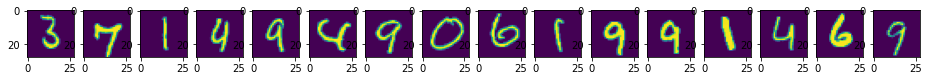

In [54]:
%matplotlib inline

data_dir = "/tmp/data"
X, _ = mnist_to_numpy(data_dir, train=False)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

In [55]:
print(samples.shape, samples.dtype)

(16, 28, 28) uint8


### Invoking the TensorFlow container

Now invoke the TensorFlow container, on the same endpoint. First normalize the sample selected and then pass the sample to the `invoke_endpoint` API.

In [56]:
tf_samples = normalize(samples, axis=(1, 2))

tf_result = runtime_sm_client.invoke_endpoint(
    EndpointName="mnist-multi-container-ep",
    ContentType="application/json",
    Accept="application/json",
    TargetContainerHostname="tensorflow-mnist",
    Body=json.dumps({"instances": np.expand_dims(tf_samples, 3).tolist()}),
)

tf_body = tf_result["Body"].read().decode("utf-8")

tf_json_predictions = json.loads(tf_body)["predictions"]


# softmax to logit
tf_predictions = np.array(tf_json_predictions, dtype=np.float32)
tf_predictions = np.argmax(tf_json_predictions, axis=1)

In [57]:
print("Predictions: ", tf_predictions.tolist())

Predictions:  [3, 7, 1, 4, 9, 4, 9, 0, 6, 1, 9, 9, 1, 4, 6, 9]


### Invoke PyTorch container

Now, invoke the PyTorch Container. In `transform_fn`, of `inference.py` it is declared that the parsed data is a python dictionary with a key `inputs` and its value should be a 1D array of length 784. Hence, create a sample inference data in the cell below.

Before we invoke the SageMaker PyTorch model server with `samples`, we need to do some pre-processing
- convert its data type to 32 bit floating point
- normalize each channel (only one channel for `MNIST`)
- add a channel dimension

In [58]:
pt_samples = normalize(samples.astype(np.float32), axis=(1, 2))

pt_result = runtime_sm_client.invoke_endpoint(
    EndpointName="mnist-multi-container-ep",
    ContentType="application/json",
    Accept="application/json",
    TargetContainerHostname="pytorch-mnist",
    Body=json.dumps({"inputs": np.expand_dims(pt_samples, axis=1).tolist()}),
)

pt_body = pt_result["Body"].read().decode("utf-8")

pt_predictions = np.argmax(np.array(json.loads(pt_body), dtype=np.float32), axis=1).tolist()
print("Predicted digits: ", pt_predictions)

Predicted digits:  [3, 9, 1, 4, 9, 4, 9, 0, 6, 1, 9, 9, 1, 4, 6, 9]


### Self Tests

In [ ]:
!pip install torch --quiet

In [ ]:
import json
import logging
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def model_fn(model_dir):
    model = Net().to(device)
    model.eval()
    return model


# data preprocessing
def input_fn(request_body, request_content_type):
    assert request_content_type == "application/json"
    data = json.loads(request_body)["inputs"]
    data = torch.tensor(data, dtype=torch.float32, device=device)
    return data


# inference
def predict_fn(input_object, model):
    with torch.no_grad():
        prediction = model(input_object)
    return prediction


# postprocess
def output_fn(predictions, content_type):
    assert content_type == "application/json"
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)

In [ ]:
model = Net().to(device)
model.eval()

In [ ]:
Body=json.dumps({"inputs": np.expand_dims(pt_samples, axis=1).tolist()})

data = input_fn(Body,'application/json')

In [ ]:
prediction = predict_fn(data, model)

In [ ]:
pt_body = output_fn(prediction,'application/json')

In [ ]:
pt_predictions = np.argmax(np.array(json.loads(pt_body), dtype=np.float32), axis=1).tolist()
print("Predicted digits: ", pt_predictions)

In [ ]:
# Download the model.tar.gz containing the PyTorch model, to current dir
S3Downloader.download(pt_mnist_model_data, ".")

# unzip the tar.gz
!tar -xvf model.tar.gz

# # after unzipping, remove the model.tar.gz
# !rm model.tar.gz

# # copy the pytorch inference script to current dir
# !cp pytorch/code/inference.py .

# # gzip the inference.py and model file together in a new model.tar.gz
# !tar -czvf model.tar.gz model.pth inference.py

# # remove the residual files
# !rm inference.py model.pth

# # upload the new tar.gz to s3
# updated_pt_model_key = "multi-container-endpoint/output/pytorch/updated"
# pt_updated_model_uri = S3Uploader.upload(
#     "model.tar.gz", "s3://{}/{}".format(bucket, updated_pt_model_key)
# )

# # remove the new model.tar.gz from the current dir
# !rm model.tar.gz

In [ ]:
model = Net().to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()

In [ ]:
Body=json.dumps({"inputs": np.expand_dims(pt_samples, axis=1).tolist()})

data = input_fn(Body,'application/json')

prediction = predict_fn(data, model)

In [ ]:
pt_body = output_fn(prediction,'application/json')

In [ ]:
pt_predictions = np.argmax(np.array(json.loads(pt_body), dtype=np.float32), axis=1).tolist()
print("Predicted digits: ", pt_predictions)


## Section 6: clean up


Before leaving this exercise, it is a good practice to delete the resources created.

In [47]:
sm_client.delete_endpoint(EndpointName="mnist-multi-container-ep")
sm_client.delete_endpoint_config(EndpointConfigName="mnist-multi-container-ep-config")
sm_client.delete_model(ModelName="mnist-multi-container")

{'ResponseMetadata': {'RequestId': '35a1bec5-d4a5-4175-843b-ffd47e478a73',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '35a1bec5-d4a5-4175-843b-ffd47e478a73',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 07 Jan 2023 01:28:49 GMT'},
  'RetryAttempts': 0}}